In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from IPython.core.debugger import set_trace

from Tools import Trainer

## Loading datasets

In [2]:
from Tools.Dataloader import datasets_loader

normalize = torchvision.transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                (0.2520022, 0.24522494, 0.24728711))
train_val_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                            normalize])

norm_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                normalize])       
                                                  
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.FiveCrop(64), # this is a list of PIL Images
    torchvision.transforms.Lambda(lambda crops: torch.stack([norm_transforms(crop) for crop in crops])), # returns a 4D tensor
])
                                                  
train_loader, valid_loader, test_loader = datasets_loader(train_val_transforms, test_transforms)

## Hyper-parameters

In [3]:
hyperparams = {'num_epochs': 2,
               'lr0' :0.1, 
               'dropout':0.2,
               'gamma': 1,
               'adjust_lr': False,
               'save_checkpoint': True      
                  }
cuda_available = torch.cuda.is_available()

## Creating the model

In [4]:
from Classifier.XavierCNN import XavierDropout

model = XavierDropout(hyperparams)
if cuda_available:
    model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams['lr0'])
criterion = nn.CrossEntropyLoss()

In [5]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
   GaussianDropout-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
   GaussianDropout-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
  GaussianDropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
             ReLU-12          [-1, 128, 32, 32]               0
  GaussianDropout-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

## Training 

In [6]:
from Tools.Trainer import Trainer

trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader, test_loader, hyperparams)
nll_train, nll_valid, acc_train, acc_valid =  trainer.train_model()
print('Done...')

------ Epoch # 1 ------
 Iteration 40: TRAIN 0.6941
 Iteration 80: TRAIN 0.6931
 Iteration 120: TRAIN 0.6915
------ Epoch # 2 ------
 Iteration 160: TRAIN 0.6890
 Iteration 200: TRAIN 0.6860
 [Loss] TRAIN 0.6812 / VALID 0.6802
 [ACC] TRAIN 0.5839 / VALID 0.5926
new checkpoint is saved!
 Iteration 240: TRAIN 0.6829
 Iteration 280: TRAIN 0.6779
Done...


## Visualization

### accuracy and loss plots

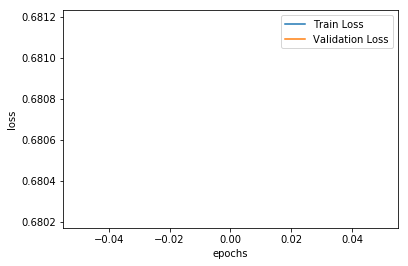

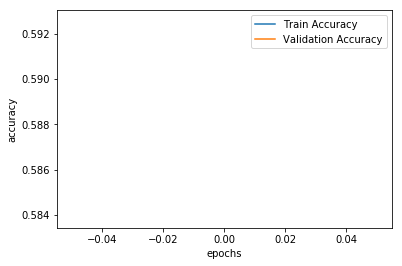

In [7]:
import Tools.Visualization as V
V.plots(nll_train, nll_valid, acc_train, acc_valid)

### Confusion Matrix

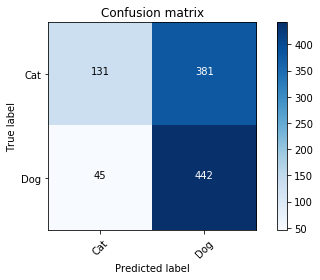

In [8]:
import Tools.Visualization as V
cnf_matrix = trainer.confusion_matrix()
V.plot_confusion_matrix(cnf_matrix)

## Saving the model

In [9]:
torch.save(model, "./Experiments/Xavier-Dropout-2-0.1-0.2")

## Generate Submission

In [18]:
import Tools.Trainer as T
results = T.predict_test_set(model, test_loader)
print(results.shape)
T.generate_submission(results)

(24995,)
Done...


In [11]:
results = T.predict_test_set_5crop(model, test_loader)
print(results.shape)
T.generate_submission(results)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [19]:
def predict_test_set_5crop(model, test_loader):
    results = [[]]
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        bs, ncrops, c, h, w = inputs.size()
        result = model(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
        result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops
        results = np.append(results, result_avg.cpu().detach().numpy())
    results = np.int8(results)
    return results

In [21]:
print(len(test_loader))

500


In [20]:
results = predict_test_set_5crop(model, test_loader)
print(results.shape)

(9998,)


In [17]:
print(results.shape)
T.generate_submission(results)

(9998,)
Done...
